# 2026-01-26 ~ 2026-02-02 進度：
### 尋找 PBTc 資料中的兩個最負相關的物性，並用 Multi-Task Lasso 來對這兩個物性建模

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import MultiTaskLasso, MultiTaskLassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor

def fit_multi_task_lasso(X_train, X_test, y_train, y_test, alpha=0.1, standard=True, interact=False, cv=0):
    pipeline_ls = []
    if standard:
        pipeline_ls.append( ( 'scaler', StandardScaler() ) )
        
    if interact:
        pipeline_ls.append( ('poly', PolynomialFeatures(interaction_only=True, include_bias=False)) )

    if cv<=0:
        base_model = MultiTaskLasso(alpha=alpha)
    else:
        alpha_ls = alpha_ls = np.arange(0, 1.01, 0.01).round(3)
        base_model = MultiTaskLassoCV(alphas=alpha_ls, cv=cv, random_state=1000)
    pipeline_ls.append( ( 'model', base_model ) )
    pipeline = Pipeline(steps=pipeline_ls)

    if standard:
        model = TransformedTargetRegressor(
            regressor=pipeline,
            transformer=StandardScaler()
        )
    else:
        model = pipeline

    # 訓練模型管線
    model.fit(X_train, y_train)

    # 預測
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # 計算 MSE
    individual_mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')

    # 計算 R-square
    r2_train = model.score(X_train, y_train)
    r2_test = model.score(X_test, y_test)
    individual_r2 = r2_score(y_train, y_train_pred, multioutput='raw_values')

    output = {
        'PIPE': model,
        'MSE': individual_mse,
        'R2': {
            'train': r2_train,
            'test': r2_test,
        },
        'INDIVIDUAL_R2':individual_r2
    }
    return output

In [2]:
# 讀取資料
datapath = '/workspaces/BO_EXPERIMENTS/src/datasets/LIMS_automl_20260105_105926_MV260final_bound_fullMerged_median_clean_10_sum100_no_rare_GF_20most_only.csv'
data = pd.read_csv(datapath)
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [3]:
# result dir
result_dir = '/workspaces/BO_EXPERIMENTS/src/results/20260204/PBTc'

# Model Save Path
model_save_dir =  os.path.join(result_dir, 'model')
os.makedirs(model_save_dir, exist_ok=True)

# plot save dir
plot_save_dir = os.path.join(result_dir, 'plot')
os.makedirs(plot_save_dir, exist_ok=True)

In [4]:
# 物性欄位
prop_cols = ['MI', 'MV', 'SPGR', 'ASH', 'TS', 'TE', 'TM', 'FS', 'FM', 'IS']
prop_data = data[prop_cols]

In [5]:
# 計算相關係數
# 皮爾森相關係數
pearson_corr = prop_data.corr(method="pearson", min_periods=3)
mask = np.triu(np.ones(pearson_corr.shape), k=0).astype(bool)
reduced_pearson_corr = pearson_corr.where(~mask) # 將矩陣的上三角給去除
sorted_pearson_pairs = reduced_pearson_corr.unstack().dropna().sort_values(ascending=False) # 扁平化矩陣順便刪除 NAN

# 斯皮爾曼相關係數
spearman_corr = prop_data.corr(method="spearman", min_periods=3)
mask = np.triu(np.ones(spearman_corr.shape), k=0).astype(bool) # 創建一個只有矩陣的上三角為 true 的矩陣
reduced_spearman_corr = spearman_corr.where(~mask) # 將矩陣的上三角給去除
sorted_spearman_pairs = reduced_spearman_corr.unstack().dropna().sort_values(ascending=False) # 扁平化矩陣順便刪除 NAN

# 選出最有負相關的兩個物性 (用斯皮爾曼相關係數，因為有剔除離群值的功能)
corr_pair = sorted_spearman_pairs
min_pair = corr_pair.idxmin() # 最有負相關的兩個物性
min_value = corr_pair.min() # 該相關係數的數字
print('最負相關的兩個項目: {} 與 {}'.format(min_pair[0], min_pair[1]))
print('相關係數: {:.3f}'.format(min_value))

最負相關的兩個項目: MI 與 MV
相關係數: -0.837


In [6]:
# 監控欄位
X = data.drop(columns=prop_cols)

# 需要被建模的物性欄位
# target_cols = list(min_pair)
target_cols = ['SPGR', 'TE' ]
Y = data[target_cols]

# 區分訓練與測試集
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [7]:
Y.describe()

,SPGR,TE
count,127.000000,127.000000
mean,1.490890,2.804295
std,0.084612,0.469790
min,1.352000,1.364000
25%,1.442500,2.547000
50%,1.453500,2.751000
75%,1.541500,3.042500
max,1.748000,4.024500


In [8]:
# 需要決定一個 alpha 值讓 lasso model 的 MSE 最低
alpha_ls = np.arange(0, 1.01, 0.01).round(3)
mse_ls = []
train_r2_ls = []
test_r2_ls = []
for alpha in alpha_ls.tolist():
    model_fit_result = fit_multi_task_lasso(X_train, X_test, y_train, y_test, alpha=alpha, standard=False)
    mse = { target_cols[i]:model_fit_result['MSE'][i].item() for i in range(len(target_cols)) }
    mse_ls.append(mse)
    train_r2_ls.append(model_fit_result['R2']['train'])

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:2712: UserWarning: Coordinate descent with l1_reg=0 may lead to unexpected results and is discouraged.
  ) = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:2712: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.951e-01, tolerance: 2.489e-03
  ) = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:2712: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.401e-03, tolerance: 2.489e-03
  ) = cd_fast.enet_coordinate_descent_multi_task(


/tmp/ipykernel_3826672/1231011960.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(fontsize='small')


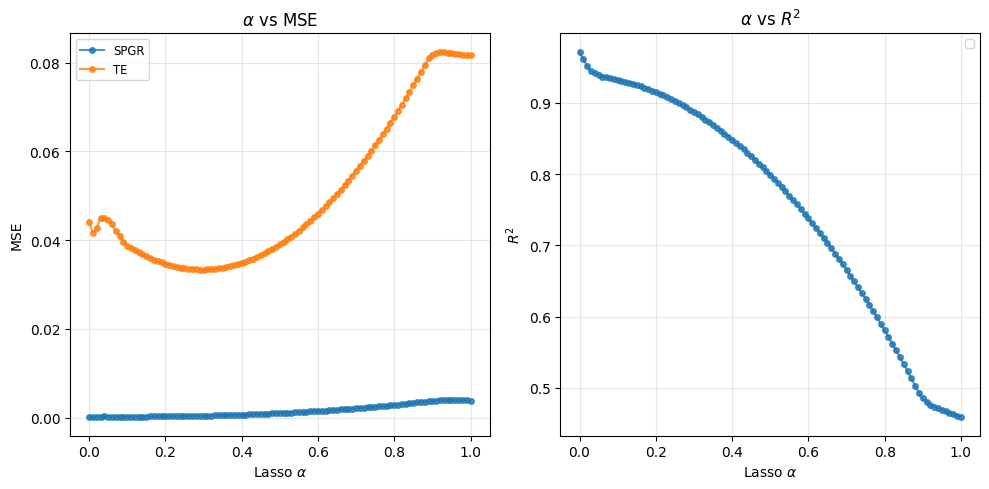

成功儲存圖表：/workspaces/BO_EXPERIMENTS/src/results/20260204/PBTc/plot/LassoAlpha.png


In [9]:
# 繪製一個 alpha vs MSE 與 R2 的趨勢圖
rows, cols = 1,2
fig, axes = plt.subplots(rows, cols, figsize=(10,5))
colors = plt.cm.tab10.colors
axes = axes.flatten()

# 繪製 alpha vs MSE
for i, target_col in enumerate(target_cols):
    color = colors[i%10]
    axes[0].plot(alpha_ls, [mse[target_col] for mse in mse_ls], label=target_col,marker='o', color=color, markersize=4, alpha=0.8)
axes[0].set_ylabel('MSE')
axes[0].set_xlabel('Lasso {}'.format(r'$\alpha$'))
axes[0].set_title('{} vs MSE'.format(r'$\alpha$'))
axes[0].grid(True, which="both", ls="-", alpha=0.3)
axes[0].legend(fontsize='small')

# 繪製 alpha vs R2
axes[1].plot(alpha_ls, train_r2_ls, marker='o', markersize=4, alpha=0.8)
axes[1].set_ylabel(r'$R^2$')
axes[1].set_xlabel('Lasso {}'.format(r'$\alpha$'))
axes[1].set_title('{} vs {}'.format(r'$\alpha$', r'$R^2$'))
axes[1].grid(True, which="both", ls="-", alpha=0.3)
axes[1].legend(fontsize='small')

plt.tight_layout()
# 儲存
output_plot_path = os.path.join(plot_save_dir, 'LassoAlpha.png')
plt.savefig(output_plot_path, dpi=200, bbox_inches='tight')
plt.show()

print(f"成功儲存圖表：{output_plot_path}")
plt.close(fig)

根據上述的 $\alpha$ vs 各項指標顯示，懲罰項係數設定為 0.03，MSE 不會變化太大

In [10]:
# 設定 alpha 為 0.1 來 train 一個 model
alpha = 0.01
model_fit_result = fit_multi_task_lasso(X_train, X_test, y_train, y_test, alpha=alpha, interact=True)


In [11]:
train_pred = model_fit_result['PIPE'].predict(X_train)

In [12]:
pd.DataFrame(y_train).describe()

,SPGR,TE
count,101.000000,101.000000
mean,1.486822,2.819480
std,0.088231,0.490995
min,1.352000,1.364000
25%,1.441000,2.615000
50%,1.450500,2.763000
75%,1.540000,3.084000
max,1.748000,4.024500


In [13]:
pd.DataFrame(train_pred).describe()

,0,1
count,101.000000,101.000000
mean,1.486822,2.819480
std,0.086164,0.470487
min,1.353559,1.412757
25%,1.443447,2.617483
50%,1.453072,2.780635
75%,1.534444,3.053557
max,1.733944,3.991787


In [14]:
# 設定 alpha 為 0.1 來 train 一個 model
alpha = 0.01
model_fit_result = fit_multi_task_lasso(X_train, X_test, y_train, y_test, alpha=alpha, interact=True)

# 觀察係數
columns = model_fit_result['PIPE'].regressor_['poly'].get_feature_names_out(X.columns)
coef_df = pd.DataFrame(
    model_fit_result['PIPE'].regressor_['model'].coef_,
    index=target_cols, columns=columns
)

# 觀察截距項
intercepts = model_fit_result['PIPE'].regressor_['model'].intercept_

print('模型係數')
print(coef_df)

print('模型常數項')
print(intercepts)

模型係數
      AA004  AA006     AW001  AW003  AW004     AW005     AX020    CM1002  \
SPGR   -0.0    0.0 -0.009831   -0.0    0.0  0.017615 -0.020936 -0.007216   
TE     -0.0   -0.0  0.017770   -0.0   -0.0 -0.042665  0.113678 -0.009293   

        CM1007  GF014  ...  PR020 PR022  PR020 PR024  PR020 SS004  \
SPGR  0.004660    0.0  ...         -0.0         -0.0     0.002110   
TE   -0.008706   -0.0  ...          0.0          0.0    -0.016582   

      PR020 SS010  PR022 PR024  PR022 SS004  PR022 SS010  PR024 SS004  \
SPGR          0.0         -0.0          0.0         -0.0         -0.0   
TE            0.0          0.0          0.0          0.0         -0.0   

      PR024 SS010  SS004 SS010  
SPGR          0.0          0.0  
TE            0.0         -0.0  

[2 rows x 210 columns]
模型常數項
[-1.0244378   0.75377094]


In [15]:
model_fit_result['PIPE'].regressor_['poly'].get_feature_names_out(X.columns).shape

(210,)

In [16]:

print('是否有不等於 0 對應 {} 的係數: {}'.format( target_cols[0], np.any(np.array(coef_df.loc[target_cols[0],:])!= 0).item() ))
coeff_ls_target_1 = list(coef_df.loc[target_cols[0],:][coef_df.loc[target_cols[0],:] != 0].index)
print('不等於 0 對應 {} 的係數數量: {}'.format(target_cols[0], len(coeff_ls_target_1)))
print(coeff_ls_target_1)

print('是否有不等於 0 對應 {} 的係數: {}'.format( target_cols[0], np.any(np.array(coef_df.loc[target_cols[1],:])!= 0).item() ))
coeff_ls_target_2 = list(coef_df.loc[target_cols[1],:][coef_df.loc[target_cols[1],:] != 0].index)
print('不等於 0 對應 {} 的係數數量: {}'.format(target_cols[0], len(coeff_ls_target_2)))
print(coeff_ls_target_2)

是否有不等於 0 對應 SPGR 的係數: True
不等於 0 對應 SPGR 的係數數量: 61
['AW001', 'AW005', 'AX020', 'CM1002', 'CM1007', 'GF020', 'PR009', 'PR020', 'PR024', 'SS004', 'AA004 AX020', 'AA004 CM1007', 'AA004 GF014', 'AA004 GF016', 'AA004 PR007', 'AA004 PR022', 'AA006 AW005', 'AA006 AX020', 'AA006 CM1007', 'AA006 GF014', 'AA006 GF016', 'AA006 SS004', 'AW001 AX020', 'AW001 CM1002', 'AW001 GF020', 'AW001 PR020', 'AW003 AX020', 'AW003 PR020', 'AW003 PR024', 'AW004 SS004', 'AW005 GF014', 'AW005 PR024', 'AX020 CM1007', 'AX020 GF016', 'AX020 PR009', 'AX020 SS010', 'CM1002 CM1007', 'CM1002 GF014', 'CM1002 GF020', 'CM1002 PR020', 'CM1007 GF020', 'CM1007 PR007', 'CM1007 PR024', 'CM1007 SS004', 'CM1007 SS010', 'GF014 GF020', 'GF014 MF001', 'GF016 GF020', 'GF016 PR009', 'GF016 PR020', 'GF016 PR024', 'GF016 SS010', 'GF020 PR007', 'GF020 PR009', 'GF020 PR020', 'GF020 SS004', 'MF001 PR020', 'PR007 PR009', 'PR007 SS004', 'PR007 SS010', 'PR020 SS004']
是否有不等於 0 對應 SPGR 的係數: True
不等於 0 對應 SPGR 的係數數量: 61
['AW001', 'AW005', 'AX020'

改用 Cross Validation 選擇 $\alpha$ 試試

In [17]:
# 1. 建立你剛才產生的 alpha 候選清單
alpha_ls = np.arange(0, 1.01, 0.01).round(3)

# 2. 建立 CV 模型 pipe
# cv=5 代表五折交叉驗證
cv_model_fit_result = fit_multi_task_lasso(X_train, X_test, y_train, y_test, alpha=alpha, standard=True, interact=True, cv=5)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:673: UserWarning: Coordinate descent with l1_reg=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.090e-02, tolerance: 1.714e-02
  model = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:673: UserWarning: Coordinate descent with l1_reg=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to incre

In [18]:
# 取得最佳 alpha
best_alpha = cv_model_fit_result['PIPE'].regressor_['model'].alpha_
print(f'最佳懲罰係數 alpha: {best_alpha}')
print('R^2: {}'.format(round(cv_model_fit_result['R2']['train'], 4)))
individual_r2 = cv_model_fit_result['INDIVIDUAL_R2']
mse = cv_model_fit_result['MSE']
print('INDIVIDUAL_R2: {},{}'.format(individual_r2.round(4)[0].item(), individual_r2.round(4)[1].item()))
print('MSE: {},{}'.format(mse.round(4)[0].item(), mse.round(4)[1].item()))

最佳懲罰係數 alpha: 0.01
R^2: 0.9859
INDIVIDUAL_R2: 0.9962,0.9757
MSE: 0.0001,0.0285


In [19]:
# 儲存 model 與 target_col
save_data = {
    'target_cols': target_cols,
    'data_cols': list(X.columns),
    'model_info':  cv_model_fit_result
}
model_save_path = os.path.join(model_save_dir, 'lasso.pkl')
joblib.dump(save_data, model_save_path)

['/workspaces/BO_EXPERIMENTS/src/results/20260204/PBTc/model/lasso.pkl']